In [ ]:
#pip install tensorflow==1.5

In [1]:
import os

In [2]:
flickr8k_set = r"C:\Users\Srividya\Downloads\Traindata\Flickr8k_Dataset\Flicker8k_Dataset"
#please provide the path 
train_images_list = os.listdir(flickr8k_set)

In [3]:
sample_size = 30
train_images_list = train_images_list[:sample_size]

In [4]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [8]:

import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import random


Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
size = (256, 256)
num_channels = 3

In [12]:
train = np.array([None] * sample_size)
real_images = np.array([None] * sample_size)

In [13]:
j = 0
for i in train_images_list:
    #print(train_images_list)
    real_images[j] = np.array(plt.imread(flickr8k_set +"\\"+ i))
    train[j] = np.array(plt.imread(flickr8k_set +"\\" + i))
    j += 1

In [14]:
j = 0
for i in train:
    train[j] = cv2.resize(i, size)
    train[j] = train[j].reshape(1, size[0], size[1], num_channels)
    j += 1

In [15]:
train = np.vstack(train[:])

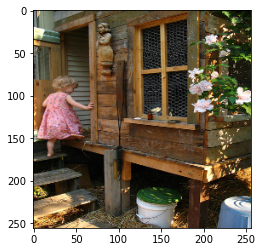

In [16]:
plt.imshow(np.squeeze(train[0]))
plt.show()

In [17]:
import pandas as pd

In [18]:
train_captions = pd.read_csv(r"C:\Users\Srividya\Downloads\Traindata\Flickr8k_Dataset\caption.csv", delimiter=',')

In [19]:
def get_images_id(names):
    names = [int(x.split('_')[-1].split('.')[0]) for x in names]
    return names

In [57]:
#ids = get_images_id(train_images_list[:sample_size])

In [20]:
train_captions.columns

Index(['image', 'caption'], dtype='object')

In [21]:
def images_map_caption(train_images_list, train_captions):
    caption = []
    for i in train_images_list:
        caption.append(train_captions[train_captions['image'] == i]['caption'].iat[0])
    return caption

In [22]:
captions = np.array(images_map_caption(train_images_list, train_captions))
print(captions.shape)

(30,)


In [23]:
import re

In [24]:
start_tag = '<s>'
end_tag = '<e>'

In [25]:
def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m
    j  = 0
    for i in captions:
        i = re.sub(' +',' ',i)
        i = start_tag + ' ' + i + ' ' + end_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(set(arr))
    vocab_size = len(arr)
    j = 0
    fwd_dict = {}
    rev_dict = {}
    j = 0
    for i in arr:
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence, fwd_dict, rev_dict

In [26]:
vocab_size, sentences, fwd_dict, rev_dict = get_vocab(captions)

In [27]:
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

In [28]:
m = len(sentences)
train_caption = [None] * m
i = 0
for sentence in sentences:
    cap_array = None
    for word in sentence:
        row = [0]
        col = [fwd_dict[word]]
        data = [1]
        if cap_array is None:
            cap_array = csr_matrix((data, (row, col)), shape=(1, vocab_size))
        else:
            cap_array = vstack((cap_array, csr_matrix((data, (row, col)), shape=(1, vocab_size))))
    train_caption[i] = cap_array
    i += 1

In [29]:
train_caption[0].shape

(20, 154)

# Model Design

## Training Model

In [30]:
def create_weights(shape, suffix):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.7), name='W_' + suffix)

def create_biases(size, suffix):
    return tf.Variable(tf.zeros([size]), name='b_' + suffix)

In [31]:
def conv_layer(inp, kernel_shape, num_channels, num_kernels, suffix):
    filter_shape = [kernel_shape[0], kernel_shape[1], num_channels, num_kernels]
    weights = create_weights(shape=filter_shape, suffix=suffix)
    biases = create_biases(num_kernels, suffix=suffix)
    layer = tf.nn.conv2d(input=inp, filter=weights, padding='SAME', strides=[1, 1, 1, 1], name='conv_' + suffix)
    layer += biases
    layer = tf.nn.relu6(layer, name='relu_' + suffix)
    #layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
    return layer



In [32]:
def flatten_layer(layer, suffix):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features], name='flat_' + suffix )
    return layer


In [33]:
def dense_layer(inp, num_inputs, num_outputs, suffix, use_relu=True):
    weights = create_weights([num_inputs, num_outputs], suffix)
    biases = create_biases(num_outputs, suffix)
    layer = tf.matmul(inp, weights) + biases
    layer = tf.nn.relu(layer)
    return layer

In [34]:
def rnn_cell(Win ,Wout, Wfwd, b, hprev, inp):
    h = tf.tanh(tf.add(tf.add(tf.matmul(inp, Win), tf.matmul(hprev, Wfwd)), b))
    out = tf.matmul(h, Wo)
    return h, out

In [35]:
import tensorflow as tf

In [ ]:
#tf.device("/device:GPU:0")

In [59]:
learning_rate = 0.0001
training_iters = 40
display_step = 1000
max_sent_limit = 50
num_tests = 12
bridge_size = 1024
keep_prob = 0.3

In [60]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [61]:
x_caption = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')
x_inp = tf.placeholder(tf.float32, shape=[1, size[0],size[1],num_channels], name='x_image')
y = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')

In [62]:
Wconv = tf.Variable(tf.truncated_normal([bridge_size, vocab_size], stddev=0.7))
bconv = tf.Variable(tf.zeros([1, vocab_size]))
Wi= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wf= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wo= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
b = tf.Variable(tf.zeros([1, vocab_size]))

In [63]:
layer_conv1 = conv_layer(inp=x_inp, kernel_shape=(3, 3), num_kernels=32, num_channels=3, suffix='1')
layer_conv2 = conv_layer(inp=layer_conv1, kernel_shape=(3, 3), num_kernels=32, num_channels=32, suffix='2')
maxpool1 = tf.nn.max_pool(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv3 = conv_layer(inp=maxpool1, kernel_shape=(3, 3), num_kernels=64, num_channels=32, suffix='3')
layer_conv4 = conv_layer(inp=layer_conv3, kernel_shape=(3, 3), num_kernels=64, num_channels=64, suffix='4')
maxpool2 = tf.nn.max_pool(layer_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv5 = conv_layer(inp=maxpool2, kernel_shape=(3, 3), num_kernels=128, num_channels=64, suffix='5')
layer_conv6 = conv_layer(inp=layer_conv5, kernel_shape=(3, 3), num_kernels=128, num_channels=128, suffix='6')
maxpool3 = tf.nn.max_pool(layer_conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv7 = conv_layer(inp=maxpool3, kernel_shape=(3, 3), num_kernels=256, num_channels=128, suffix='7')
layer_conv8 = conv_layer(inp=layer_conv7, kernel_shape=(3, 3), num_kernels=256, num_channels=256, suffix='8')

In [64]:
flat_layer = flatten_layer(layer_conv8, suffix='9')
#flat_layer = tf.layers.dropout(flat_layer, rate= keep_prob)
dense_layer_1 = dense_layer(inp=flat_layer, num_inputs=262144 , num_outputs=bridge_size, suffix='10')

In [65]:
start_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[start_tag]])), shape=(1, vocab_size)).A, tf.float32)
end_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[end_tag]])), shape=(1, vocab_size)).A, tf.float32)

In [66]:
hook = tf.slice(x_caption, [0, 0], [1, vocab_size])
h = dense_layer_1
h, out = rnn_cell(Wi ,Wo, Wconv, bconv, h, hook)

In [67]:
def fn(prev, curr):
    h = prev[0]
    curr = tf.reshape(curr, [1, vocab_size])
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, curr)
    return h, out

In [68]:
_, output = tf.scan(fn, x_caption[1:], initializer=(h, out))

In [69]:
output = tf.squeeze(output, axis  = 1)

In [70]:
outputs = tf.concat([out, output], axis = 0)

In [71]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [72]:
pred = tf.nn.softmax(outputs)

In [73]:
# Model evaluation
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Predictive Model

In [74]:
out_tensor = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size = 0)

In [75]:
htest = dense_layer_1
htest, out_first = rnn_cell(Wi ,Wo, Wconv, bconv, htest, start_hook)
t = 0
out_ = tf.one_hot(tf.argmax(tf.nn.softmax(out_first), 1), depth=vocab_size)
out_tensor = out_tensor.write(t, out_)
t += 1

In [76]:
def condition(res, h, out_tensor, t):
    return tf.logical_and(tf.logical_not(tf.equal(tf.argmax(res, 1)[0], fwd_dict[end_tag])), tf.less(t, max_sent_limit))

In [77]:
def action(res, h, out_tensor, t):
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, res)
    res = tf.one_hot(tf.argmax(tf.nn.softmax(out), 1), depth=vocab_size)
    out_tensor = out_tensor.write(t, res)
    return res, h, out_tensor, t + 1

In [78]:
_, __, final_outputs, T = tf.while_loop(condition, action, [out_, htest, out_tensor, t])

In [79]:
final_prediction = tf.squeeze(final_outputs.stack())

In [80]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

# Model Implemetation

1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
Optimization finished!
Let's check
(50, 154)
4
Predicted Caption:-> A big collage glass in spotted near from front lays one by white rope water yellow red orange standing collage uses black head entry paint pictures nearby snow through pictures blue is woman skier hands grassy get her sprinkler lawn covered skyscraper rainbow white covered dogs building covered tent 
Orignal Caption:-> A dog shakes its head near the shore , a red ball next to it . 


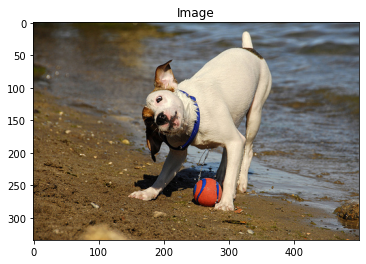

(50, 154)
4
Predicted Caption:-> A an his waters different are Two dogs play man pink of <s> brown city her . crouches . white water bowl boy building grass crampons the in toy playing crampons set leaps fence up chases Two crampons an baby snow brown surf stairs jumping grassy grass an baby 
Orignal Caption:-> A black dog and a spotted dog are fighting 


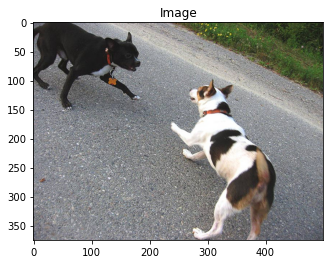

(50, 154)
4
Predicted Caption:-> white her scale at goalie city near brown dogs paint couple yellow goalie <s> leaps carries girl . covered up prepares paint spotted lays by white net thrown something sitting nearby man yellow shakes skyscraper air rope up surf crouches field through man front rainbow a starring Two rainbow 
Orignal Caption:-> A black and white dog is running in a grassy garden surrounded by a white fence . 


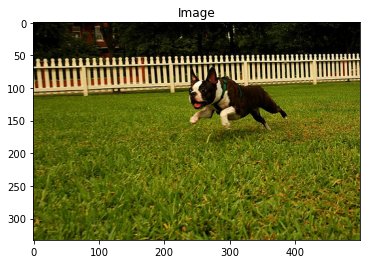

(50, 154)
4
Predicted Caption:-> stick its crouches play her kayak and are white water infant near crouches brown grassy dress ice one spotted hat A shore infant he play chases blue thrown rope waters little fence crouches get the rope fighting crouches yellow while rainbow cliff A breeds grassy next brown on breeds 
Orignal Caption:-> A boy smiles in front of a stony wall in a city . 


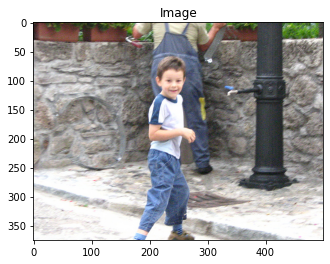

(50, 154)
4
Predicted Caption:-> A spotted by starring stroller on orange brown sits hole carries log playing water sits painted different , as carries wall stroller while of , stairs city different painted stony modern white woman glass dogs rainbow it bench mouth woman net hands wall crampons up by a brown sprinkler 
Orignal Caption:-> a man is standing in front of a skyscraper 


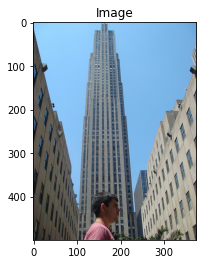

(44, 154)
4
Predicted Caption:-> building black collage skier yellow bowl woman pictures infant person skyscraper infant log paint carries wall . her painted girl rope cliff cliff water the something net something starring near three way something shore up surf infant crouches skyscraper beach are nearby fighting 
Orignal Caption:-> A child in a pink dress is climbing up a set of stairs in an entry way . 


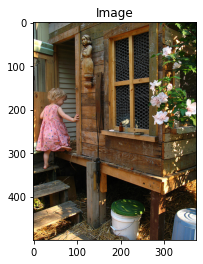

(50, 154)
4
Predicted Caption:-> white paint Two play different on lawn bench breeds brown building head A entry bowl its nearby rainbow the big carries child big hands big log next paint sits . uses at mouth stony playing jumping up at to leaps him . covered rope net stick white near spotted 
Orignal Caption:-> Two different breeds of brown and white dogs play on the beach . 


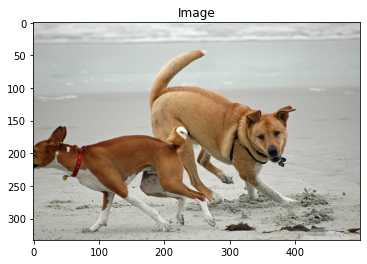

(50, 154)
4
Predicted Caption:-> A spotted by starring stroller on orange brown sits hole carries log playing water sits painted different , as carries wall stroller while of , stairs city different painted stony modern white woman glass dogs rainbow it bench mouth woman net hands wall crampons up by a brown sprinkler 
Orignal Caption:-> a man is standing in front of a skyscraper 


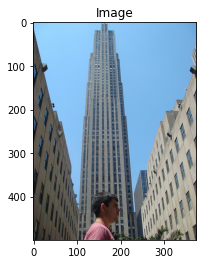

(50, 154)
4
Predicted Caption:-> object child man object to on near black up structure fighting child set air bowl near waters toy Two brown hat person different front are crouches of beach him log man through on couple standing fence baby brown child kayak big one a different get big shore man way 
Orignal Caption:-> A dog prepares to catch a thrown object in a field with nearby cars . 


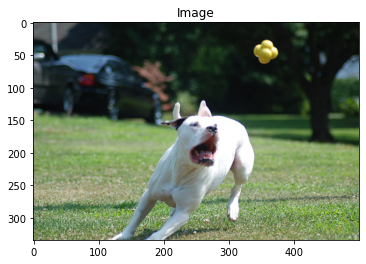

(50, 154)
4
Predicted Caption:-> A dress man starring city through big shore him girl grass in smiles the pictures goalie dog grass up garden white near spotted baby crampons black rope scale infant stick drilling object waters sits art bowl shore by spotted nearby scale wall carries through garden dress it red grass 
Orignal Caption:-> A man lays on a bench while his dog sits by him . 


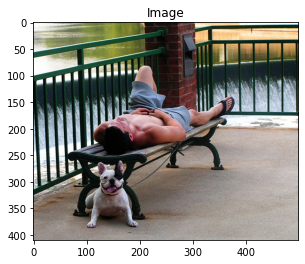

(50, 154)
4
Predicted Caption:-> cars black Two crouches through spotted dress surf cliff Two dress sitting wall man something boy stroller yellow infant the . girl head one stony up <s> it standing crouches goalie something climbing air modern are <s> pond cars male stick white beach red infant his <s> surf . 
Orignal Caption:-> A man and a baby are in a yellow kayak on water . 


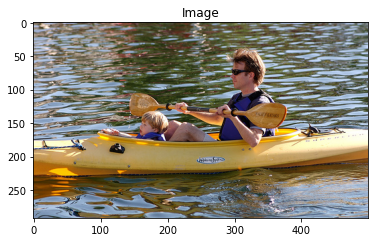

(50, 154)
4
Predicted Caption:-> white paint Two play different on lawn bench breeds brown building head A entry bowl its nearby rainbow the big carries child big hands big log next paint sits . uses at mouth stony playing jumping up at to leaps him . covered rope net stick white near spotted 
Orignal Caption:-> Two different breeds of brown and white dogs play on the beach . 


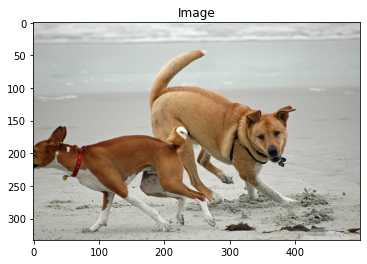

In [81]:
with tf.Session() as sess:
    sess.run(init)
    print(1)
    m = len(train_caption)
    for epoch in range(training_iters):
        total_cost = 0
        total_acc = 0
        print(2)
        for i in range(m):
            _, cst, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x_caption:train_caption[i][:-1].A, x_inp:train[i:i+1], y:train_caption[i][1:].A})
            total_cost += cst
            total_acc += acc
        if (epoch + 1) % display_step == 0:
            print('After ', (epoch + 1), 'iterations: Cost = ', total_cost / m, 'and Accuracy: ', total_acc * 100/ m , '%' )
    print('Optimization finished!')
    print("Let's check")
    for tests in range(num_tests):
        image_num = random.randint(0, sample_size - 1)
        caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
        print(caption.shape)
        caption = np.argmax(caption[:-1], 1)
        capt = ''
        print(4)
        for i in caption:
            capt += rev_dict[i] + ' '
        print('Predicted Caption:->', capt)
        orig_cap = np.argmax(train_caption[image_num:image_num + 1][0][1:-1].A, 1)
        orignalcaption = ''
        for i in orig_cap:
            orignalcaption += rev_dict[i] + ' '
        print('Orignal Caption:->', orignalcaption)
        plt.imshow(real_images[image_num])
        plt.title('Image')
        plt.show()